# Imports

In [9]:
import torch
import logging
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils.arg_extract import get_args
from utils.experiment_evaluator import evaluate_experiment
from utils.experiment import Experiment
from argparse import Namespace
from utils.experiment_evaluator import image_prepro, create_evaluation_dataloader, get_test_predictions_pairs, save_sequence_plots
import os
from utils.io import save
plt.ioff()
from utils.io import load
batch_images_all = load('batches.pickle')

import configparser
config = configparser.ConfigParser()
config.read('../config.ini')
# config['paths']['exp_folder']
        
data_directory = config['paths']['data_base']
experiments = [dI for dI in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, dI))]

# Model

In [10]:
exp = 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3'
model_name = 'Causal\nLSTM-R'
# output_frames_int, target_frames = get_experiment_predictions(exp_name, batch_images, belated=False)
# output_frames_bel, target_frames = get_experiment_predictions(exp_name, batch_images, belated=True)

belated = False
dd = {'experiment_name': exp,
        'num_epochs': 1,
        'num_workers': 1,
        'test_starting_point': 15,
        'num_total_output_frames':80,
        'debug': False}

args_new = Namespace(**dd)
experiment = Experiment(args_new)
experiment.device='cpu'
experiment.load_from_disk(test=True)

# Viz latent space of PredRNN

In [12]:
model = experiment.model.cpu()
params = model.cpu().state_dict()

In [17]:
import scipy as scp
def show_kernels(param, lines, rows, interp='nearest', feature_map=0, deconv=False):
    p0 = params[param+'.weight']
    print(p0.size())
    fig, axarr = plt.subplots(lines, rows, figsize=(rows, lines))

    for i in range(lines):
        for k in range(rows):
            kk = i * rows + k
            if kk < p0.size(0 if deconv else 1):
                img = p0[kk, feature_map, :] if deconv else p0[feature_map, kk, :] 
                img = scp.ndimage.zoom(img, zoom=3)
                axarr[i, k].imshow(img, cmap='gray', interpolation=interp, vmin=p0.min(), vmax=p0.max())
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])
    plt.show()

In [21]:
def mean_activation_histogram(param, deconv=False):
    p0 = params[param+'.weight']
    p0b = params[param+'.bias']
    dim = (0,2,3) if deconv else (1,2,3)
    pp = p0.mean(dim) + p0b
    plt.hist(pp)
    plt.show()

# First layer kernels

torch.Size([8, 1, 3, 3])


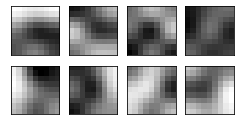

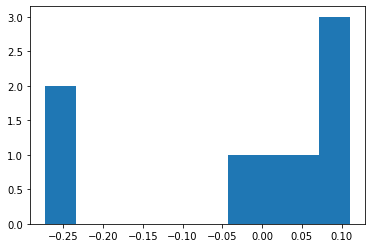

In [47]:
lines = 2
rows = 4
feature_map = 0

param = 'conv'
show_kernels(param, lines, rows, interp='nearest', feature_map=feature_map, deconv=True)
mean_activation_histogram(param,deconv=False)

In [58]:
params['conv.weight'].mean((1,2,3))

tensor([ 0.0476,  0.0095, -0.0505, -0.1423,  0.0213, -0.0223,  0.0982,  0.1117])

In [51]:
params['conv.bias']

tensor([ 0.0625,  0.0138, -0.2220,  0.2184, -0.2711,  0.1324, -0.0564, -0.1534])

# Recurrent kernels

torch.Size([256, 64, 3, 3])


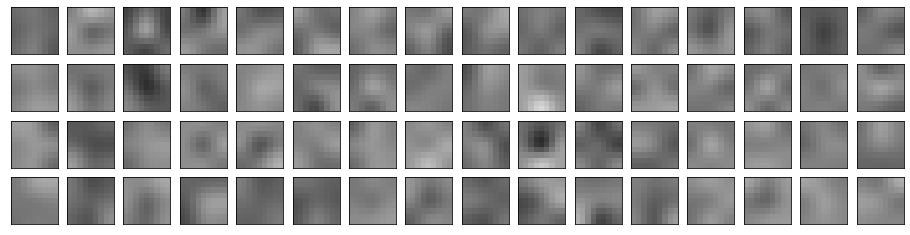

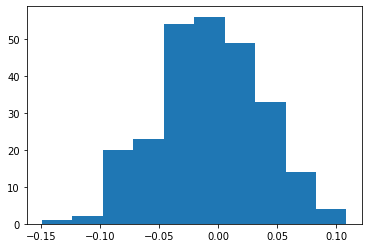

In [64]:
lines = 4
rows = 16
feature_map = 0

param = 'lstm.0.conv_h'
show_kernels(param, lines, rows, interp='nearest', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([256, 64, 3, 3])


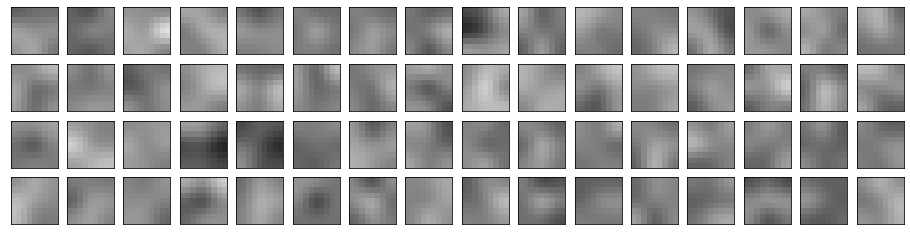

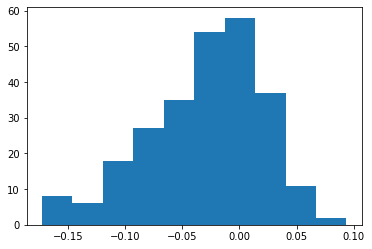

In [68]:
lines = 4
rows = 16
feature_map = 0

param = 'lstm.1.conv_h'
show_kernels(param, lines, rows, interp='nearest', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([256, 64, 3, 3])


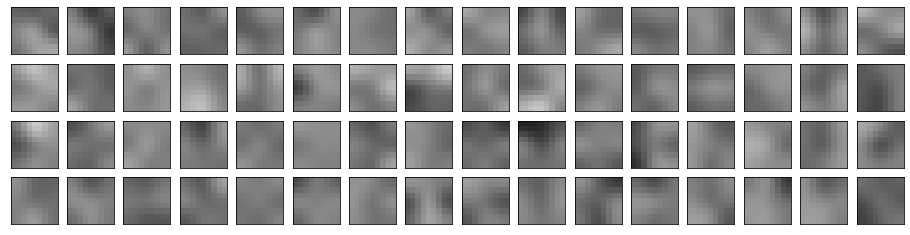

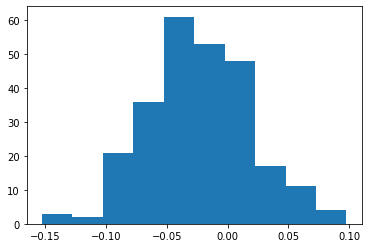

In [70]:
lines = 4
rows = 16
feature_map = 0

param = 'lstm.3.conv_h'
show_kernels(param, lines, rows, interp='nearest', feature_map=feature_map)
mean_activation_histogram(param)

# Deconv kernels

torch.Size([64, 1, 7, 7])


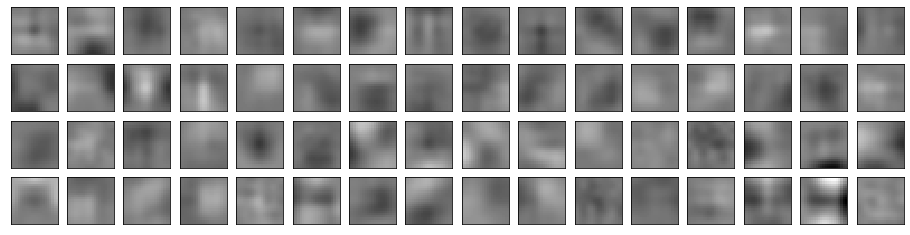

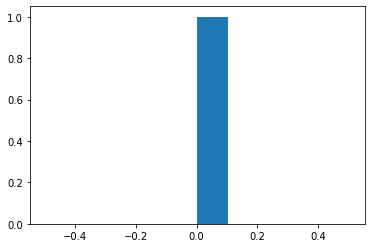

In [71]:
lines = 4
rows = 16
index = 2
feature_map = 0

param = 'deconv'
show_kernels(param, lines, rows, interp='nearest', feature_map=feature_map, deconv=True)
mean_activation_histogram(param, deconv=True)

In [29]:
# Visualize feature maps
activation = {}
hooks = {}

In [72]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output #.detach()
    return hook

In [73]:
for n,h in hooks.items():
    h.remove()

for name, module in model.named_modules():
    hooks[name] = module.register_forward_hook(get_activation(name))

# Visualize feature maps

In [74]:
# 'Test_1', 'Test_2', 'Test_3', 
# 'Lines_1', 'Lines_2', 'Lines_3',
# 'Double_Drop_1', 'Double_Drop_2', 'Double_Drop_3', 
# 'Illumination_135_1', 'Illumination_135_2', 'Illumination_135_3', 
# 'Illumination_Random_1', 'Illumination_Random_2', 'Illumination_Random_3', 
# 'Shallow_Depth_1', 'Shallow_Depth_2', 'Shallow_Depth_3', 
# 'Smaller_Tub_1', 'Smaller_Tub_2', 'Smaller_Tub_3', 
# 'Bigger_Tub_1', 'Bigger_Tub_2', 'Bigger_Tub_3', 
# 'Fixed_Tub_1', 'Fixed_Tub_2', 'Fixed_Tub_3'

test_set = 'Smaller_Tub_1'
batch_images = batch_images_all[test_set]

starting_point = 10
num_total_output_frames = 80
batch_index=0
model.eval()
num_input_frames = model.get_num_input_frames()
with torch.no_grad():
    input_end_point = starting_point + num_input_frames
    input_frames = batch_images[batch_index:batch_index+1, starting_point:input_end_point, :, :].clone()
    output_frames = model.get_future_frames(input_frames, num_total_output_frames, belated=True)
    target_frames = batch_images[batch_index:batch_index+1, input_end_point:(input_end_point + num_total_output_frames), :, :]
    
output_frames = image_prepro(output_frames, experiment.normalizer)
target_frames = image_prepro(target_frames, experiment.normalizer)
input_frames = image_prepro(input_frames, experiment.normalizer)

output_frames.size()

torch.Size([1, 80, 128, 128])

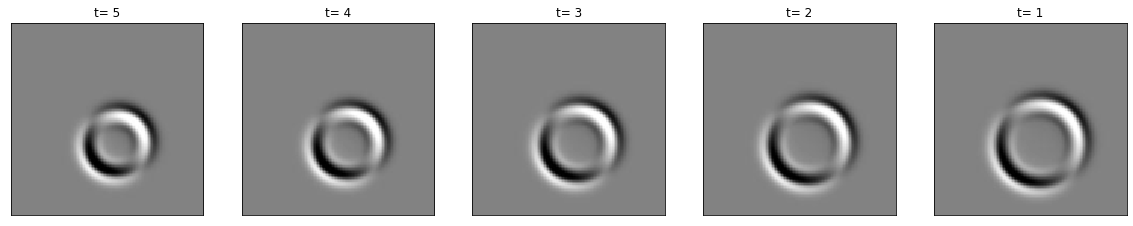

In [75]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for t in range(5):
    ax[t].imshow(input_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
    ax[t].set_title('t= %d' % (5-t))
    ax[t].get_xaxis().set_ticks([])
    ax[t].get_yaxis().set_ticks([])
plt.show()

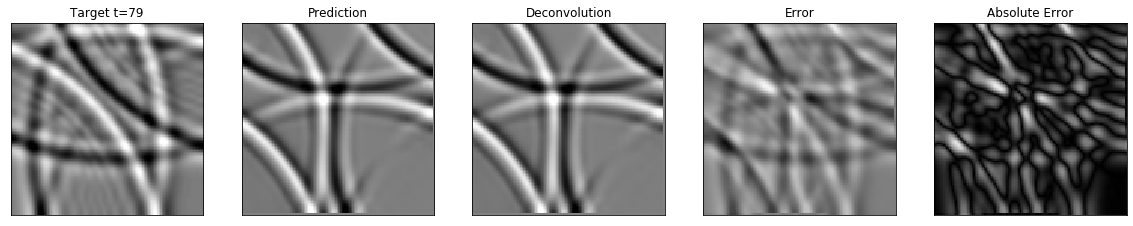

Deconv and Prediction error (should be zero): 0.000000
prediction error 0.189571


In [76]:
dconv_norm = image_prepro(activation['deconv'].squeeze(), experiment.normalizer)
t=num_total_output_frames-1
fig, ax = plt.subplots(1, 5, figsize = (20, 4))
ax[0].imshow(target_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(output_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[2].imshow(dconv_norm, cmap='gray', vmin=0, vmax=1)
ax[3].imshow((target_frames[0, t, :, :] - output_frames[0, t, :, :]), cmap='gray', vmin=-1, vmax=1)
ax[4].imshow(abs(target_frames[0, t, :, :] - output_frames[0, t, :, :]), cmap='gray', vmin=0, vmax=1)

ax[0].set_title('Target t=%d'%t)
ax[1].set_title('Prediction')
ax[2].set_title('Deconvolution')
ax[3].set_title('Error')
ax[4].set_title('Absolute Error')

for a in ax:
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
plt.show()

print('Deconv and Prediction error (should be zero): %f' % (output_frames[0, t, :, :] - dconv_norm).abs().mean())
print("prediction error %f" % (target_frames[0, t, :, :] - dconv_norm).abs().mean())

In [77]:
activation['lstm.1.conv_m'].size()

torch.Size([1, 192, 31, 31])

In [78]:
plt.imshow(image_prepro(activation['lstm.3.conv_h'].squeeze().mean(0), experiment.normalizer), cmap='gray')
plt.colorbar()

In [79]:
plt.imshow(image_prepro(activation['lstm.3.conv_m'].squeeze().mean(0), experiment.normalizer), cmap='gray')
plt.colorbar()

In [80]:
def print_activations(act_name):
    act = activation[act_name].squeeze()
    print(act.size())
    lines = 8
    rows = 16
    fig, axarr = plt.subplots(lines, rows, figsize=(16, 8))
    for i in range(lines):
        for k in range(rows):
            if (i*lines+k >= act.size(0)):
                continue
            axarr[i, k].imshow(image_prepro(act[i*lines+k,:], experiment.normalizer), cmap='gray', vmin=0, vmax=1)
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])
    plt.show()

torch.Size([256, 31, 31])


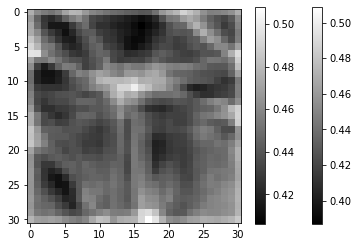

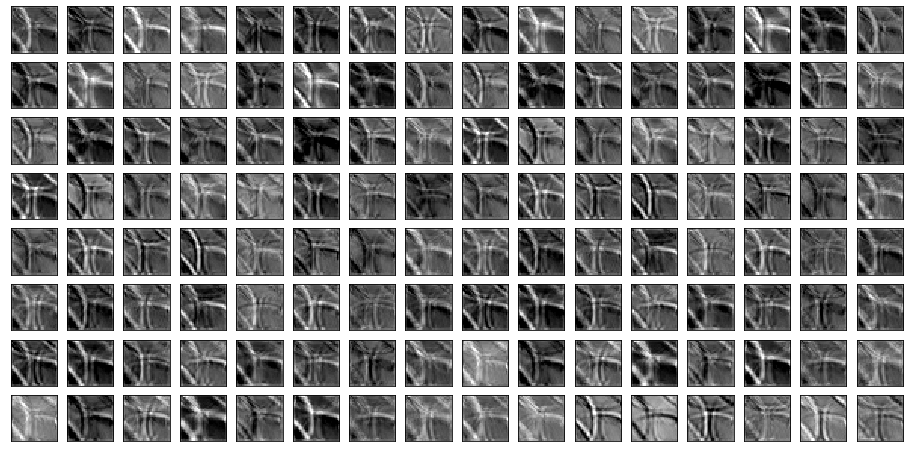

In [81]:
print_activations('lstm.0.conv_h')

torch.Size([256, 31, 31])


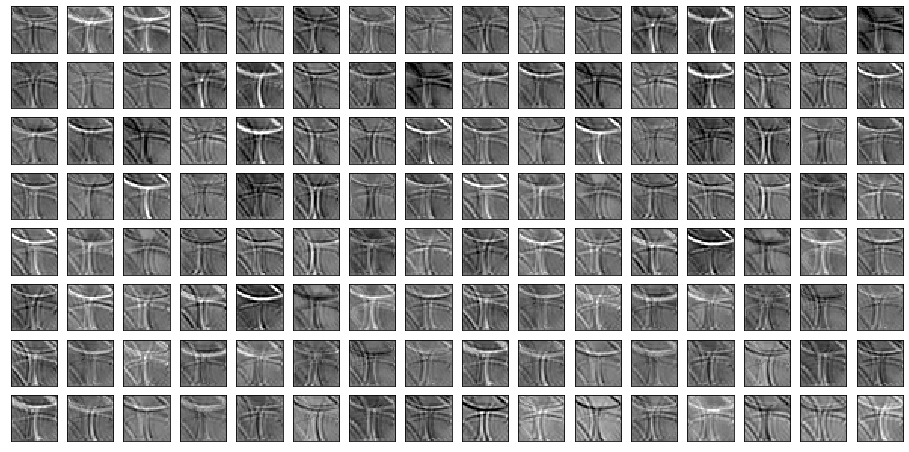

In [82]:
print_activations('lstm.1.conv_h')

torch.Size([256, 31, 31])


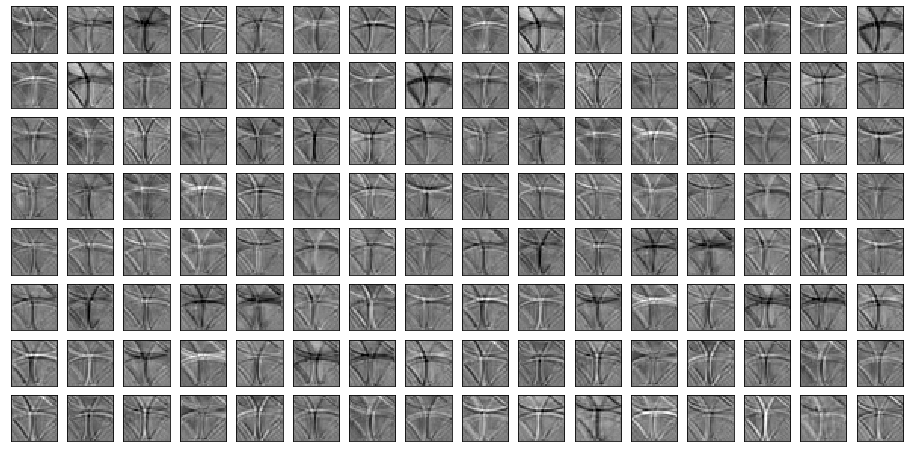

In [83]:
print_activations('lstm.2.conv_h')

torch.Size([256, 31, 31])


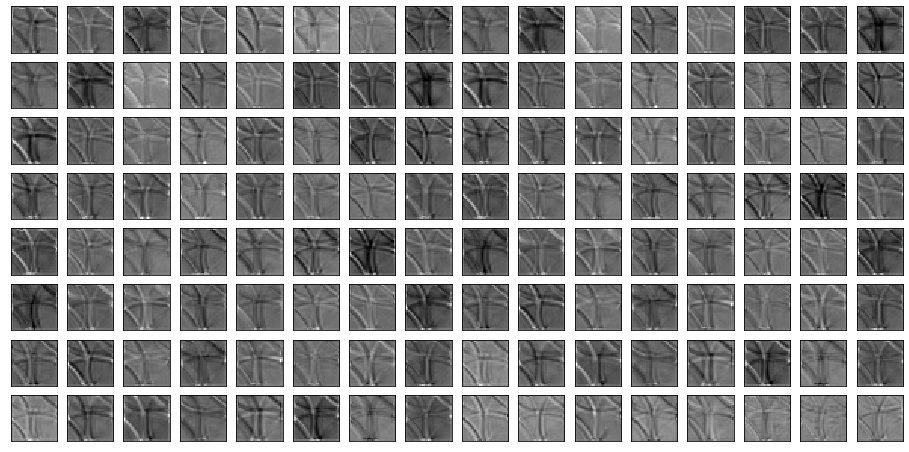

In [84]:
    print_activations('lstm.3.conv_h')

In [68]:
#  print_activations('lstm.0.conv_c')

In [69]:
# print_activations('lstm.0.conv_m')

In [70]:
# print_activations('lstm.0.conv_x')

In [71]:
# print_activations('lstm.0.conv_o')